# Index
* [Load the data](#Load-the-data)
* [Extract features and find pattern](#Extract-features-and-find-pattern)
    * [decide a video is popular or not](#decide-a-video-is-popular-or-not)
    * [decide a video's trending status](#decide-a-video's-trending-status)
* [Answer question 1](#Answer-question-1)
* [Answer question 2](#Answer-question-2)
    * [Upload weekday impact](#Upload-weekday-impact)
    * [Language impact](#Language-impact)
    * [Model by Decision Tree](#Model-by-Decision-Tree)
    * [Main characters of Hot videos](#Main-characters-of-Hot-videos)
* [Answer question 3](#Answer-question-3)

In [1]:
import itertools
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,export_graphviz

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Load the data

In [2]:
vcounts = pd.read_csv("video_count.csv")
vcounts['date'] = pd.to_datetime(vcounts.date)

# since 'count' name-conflicts method name, so rename it to 'view_count'
vcounts.rename(columns={'count':'view_count'},inplace=True)

In [3]:
vcounts.sample(5) # galance the data

,video_id,view_count,date
28179,1631,12067,2015-01-09
9921,2471,273324,2015-01-12
26668,2643,1105515,2015-01-03
20847,758,2767,2015-01-01
5698,2405,1317190,2015-01-13


In [6]:
vfeatures = pd.read_csv("video_features.csv",index_col='video_id')
# rename to short names, makes it easier to be displayed
vfeatures.rename(columns={'video_length':"length",
                          'video_language':"language",
                          'video_upload_date':'upload_date',
                          'video_quality':'quality'},inplace=True)
vfeatures['upload_date'] = pd.to_datetime(vfeatures.upload_date)

# remove the last 'p', change it from string to int
vfeatures['quality'] = vfeatures.quality.map(lambda s: int(s[:-1]))

In [7]:
vfeatures.head()

,length,language,upload_date,quality
video_id,,,,
2374,1760,Cn,2014-12-06,480
1897,489,Cn,2014-12-10,720
2386,1273,Es,2014-12-05,480
2912,986,Es,2014-12-10,240
2432,1050,Other,2014-12-10,480


In [8]:
vfeatures.sample(5) # galance the data

,length,language,upload_date,quality
video_id,,,,
2531,480,En,2014-12-17,1080
840,142,Other,2014-12-24,1080
2076,1063,Other,2014-12-03,720
380,1837,Other,2014-12-10,240
2588,789,En,2014-12-06,720


In [9]:
vfeatures.upload_date.describe()

count                    2785
unique                     23
top       2014-12-10 00:00:00
freq                      242
first     2014-12-02 00:00:00
last      2014-12-24 00:00:00
Name: upload_date, dtype: object

In [10]:
vcounts.date.describe()

count                   41775
unique                     15
top       2015-01-10 00:00:00
freq                     2785
first     2015-01-01 00:00:00
last      2015-01-15 00:00:00
Name: date, dtype: object

# Extract features and find pattern

In [14]:
def extract_counts_statistics(df):
    """
    input:
        DataFrame of a certain video (same video_id)
    output:
        25th,50th,75th,mean of that video's view_count
        25th,50th,75th,mean of that video's view_count's change rate
    """
    counts = df.sort_values(by='date')['view_count'].astype(np.float)
    qs = [25,50,75]

    # ************* count's statistics ************* #
    cnt_percentiles = np.percentile(counts,qs)
    d = {'cnt_{}th'.format(q):p for q,p in zip(qs,cnt_percentiles)}
    d['cnt_mean'] = counts.mean()

    # ************* count's change rate's statistics ************* #
    # change rate = 'current view counts'/'previous view counts'
    cnts_prev = counts.iloc[:-1]
    cnts_current = counts.iloc[1:]
    # divide by values, not match by index
    change_rates = cnts_current.values / cnts_prev.values

    chg_percentiles = np.percentile(change_rates,qs)
    for q,p in zip(qs,chg_percentiles):
        # 'rch' stands for 'rate of change'
        d['rch_{}th'.format(q)] = p
    d['rch_mean'] = change_rates.mean()

    return pd.Series(d)

In [15]:
vstatistics = vcounts.groupby('video_id').apply(extract_counts_statistics)

In [16]:
vstatistics.head()

,cnt_25th,cnt_50th,cnt_75th,cnt_mean,rch_25th,rch_50th,rch_75th,rch_mean
video_id,,,,,,,,
1,41099.0,65907.0,96335.0,7.063560e+04,0.813619,0.848616,0.932023,0.872563
2,1673415.5,1718352.0,1782226.5,1.737141e+06,0.938541,0.956124,1.030687,0.985816
3,2132336.5,2247587.0,2436222.5,2.292781e+06,0.971707,0.998932,1.056393,1.008923
4,2611162.0,2719547.0,2880268.5,2.740392e+06,0.972875,1.001606,1.050860,1.011310
5,255574.5,388594.0,609508.0,4.479973e+05,0.822568,0.866553,0.987271,0.888189


## decide a video is popular or not

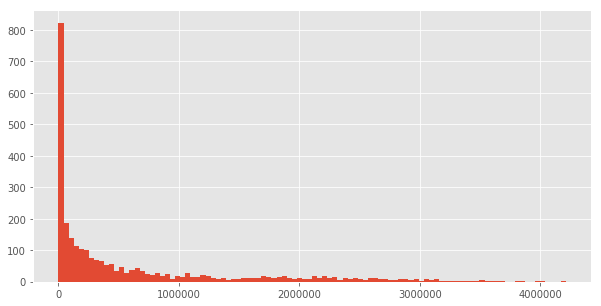

In [18]:
plt.figure(figsize=(10,5))
_ = plt.hist(vstatistics.cnt_mean,bins=100)

In [19]:
cnt_cutoff = 1000000
(vstatistics.cnt_mean >= cnt_cutoff).mean()

0.22621184919210055

there are 23% of the videos which can have average daily view_count higher than 100,0000. 23% matches my assumption about the popular videos, so I decide to choose 100,0000 as a cutoff to decide the video is popular or not. 

In [20]:
vstatistics['is_popular'] = vstatistics.cnt_mean >= cnt_cutoff

## decide a video's trending status

C:\Users\Vin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


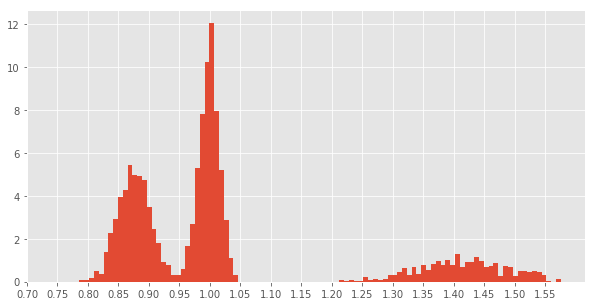

In [21]:
plt.figure(figsize=(10,5))
plt.hist(vstatistics.rch_mean,bins=100,normed=True)
_ = plt.xticks(np.arange(0.7,1.6,0.05))

we can see the average 'rate of change' is clearly splitted into three groups:
* average 'rate of change' < 0.95, the video's trending is decreasing
* average 'rate of change' is between 0.95 and 1.05, the video's trending is flat
* average 'rate of change' > 1.05, the video's trending is increasing, aka. ** 'Hot' **.

In [22]:
rch_bins = [0,0.95,1.05,100]
vstatistics['trend_status'] = pd.cut(vstatistics.rch_mean,rch_bins,right=False,labels=['decrease','flat','increase'])

In [23]:
vstatistics.trend_status.value_counts()

flat        1272
decrease    1013
increase     500
Name: trend_status, dtype: int64

# Answer question 1
<span style='color:blue'>Classify each video into one the 3 categories below and explain your approach: </span>
* <span style='color:blue'>"Hot" - means trending up. These videos are candidate to be shown. </span>
* <span style='color:blue'>"Stable and Popular" - video view counts are ﬂat, but very high. These videos are candidates to be shown too. </span>
* <span style='color:blue'>"Everything else" - these videos won't be shown.</span>

In [24]:
videos = vfeatures
videos = videos.join(vstatistics.loc[:,['is_popular','trend_status']])

In [25]:
videos.head()

,length,language,upload_date,quality,is_popular,trend_status
video_id,,,,,,
2374,1760,Cn,2014-12-06,480,False,decrease
1897,489,Cn,2014-12-10,720,True,flat
2386,1273,Es,2014-12-05,480,False,decrease
2912,986,Es,2014-12-10,240,False,decrease
2432,1050,Other,2014-12-10,480,False,decrease


Just as mentioned above, 
* [average view counts > 1000000 are considered as popular](#decide-a-video-is-popular-or-not).
* [average 'rate of change' > 1.05 are considered as trending up, aka, 'Hot'](#decide-a-video's-trending-status).

In [26]:
status = pd.Series('Everything else',index = videos.index)
status.loc[ videos.trend_status == 'increase'] = 'Hot'
status.loc[ (videos.trend_status == 'flat') & videos.is_popular] = 'Stable and Popular'

In [27]:
status.value_counts()

Everything else       1701
Stable and Popular     584
Hot                    500
dtype: int64

In [28]:
videos.groupby(status).apply(lambda df: df.shape[0])

Everything else       1701
Hot                    500
Stable and Popular     584
dtype: int64

# Answer question 2
<span style='color:blue'>What are the main characteristics of the "hot videos"?</span>

In [29]:
X = videos.copy()
X.head()

,length,language,upload_date,quality,is_popular,trend_status
video_id,,,,,,
2374,1760,Cn,2014-12-06,480,False,decrease
1897,489,Cn,2014-12-10,720,True,flat
2386,1273,Es,2014-12-05,480,False,decrease
2912,986,Es,2014-12-10,240,False,decrease
2432,1050,Other,2014-12-10,480,False,decrease


In [30]:
X['is_hot'] = (X.trend_status == 'increase').astype(int)
del X['is_popular']
del X['trend_status']

## Upload weekday impact

In [31]:
X.upload_date.describe()

count                    2785
unique                     23
top       2014-12-10 00:00:00
freq                      242
first     2014-12-02 00:00:00
last      2014-12-24 00:00:00
Name: upload_date, dtype: object

since all upload happen in December, so upload month won't be a factor. the only possible factor is ** upload weekday **.

In [32]:
X['upload_weekday'] = X.upload_date.dt.weekday_name
del X['upload_date']

In [33]:
X.head()# galance

,length,language,quality,is_hot,upload_weekday
video_id,,,,,
2374,1760,Cn,480,0,Saturday
1897,489,Cn,720,0,Wednesday
2386,1273,Es,480,0,Friday
2912,986,Es,240,0,Wednesday
2432,1050,Other,480,0,Wednesday


In [34]:
weekday_hot = X.groupby(by='is_hot').apply(lambda df: df.upload_weekday.value_counts(normalize=True)).unstack()
weekday_hot = weekday_hot.loc[:,["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]]
weekday_hot

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
is_hot,,,,,,,
0,0.100219,0.099781,0.19081,0.210941,0.198249,0.108096,0.091904
1,0.132000,0.174000,0.20200,0.190000,0.112000,0.106000,0.084000


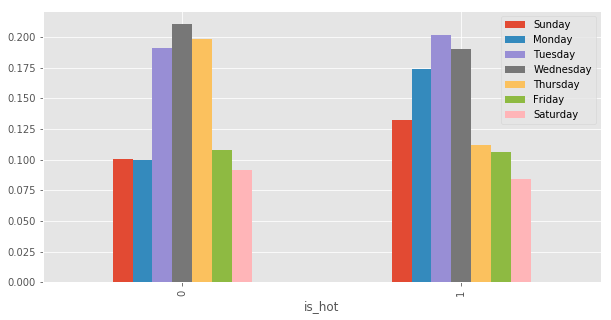

In [35]:
weekday_hot.plot(kind='bar',figsize=(10,5))

from above plot, we can see in Hot videos, <span style='color:orange;font-size:1.5em'>the ones uploaded on Sunday and Monday occupy a higher ratio than Not Hot videos. this may because these videos have longer "offline propagation time"</span> than the ones uploaded at the second half of the week.

## Language impact

In [36]:
language_hot = X.groupby(by='is_hot').apply(lambda df: df.language.value_counts(normalize=True)).unstack()
language_hot

,Cn,De,En,Es,Fr,Other
is_hot,,,,,,
0,0.301094,0.027571,0.285339,0.131291,0.027133,0.227571
1,0.300000,0.012000,0.368000,0.116000,0.032000,0.172000


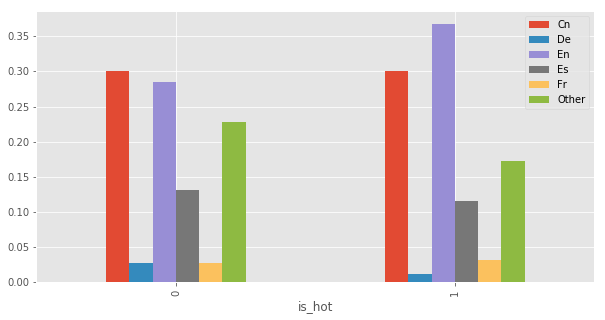

In [37]:
language_hot.plot(kind='bar',figsize=(10,5))

we can see vidoes in English occupies a higher ratio in Hot videos than in Not-Hot videos.

## Model by Decision Tree
since the purpose is studying the feature importance, so no need to split train/validation/test set, just fit a shallow Decision Tree on all the data

In [38]:
X.head()

,length,language,quality,is_hot,upload_weekday
video_id,,,,,
2374,1760,Cn,480,0,Saturday
1897,489,Cn,720,0,Wednesday
2386,1273,Es,480,0,Friday
2912,986,Es,240,0,Wednesday
2432,1050,Other,480,0,Wednesday


In [39]:
X.language.value_counts()

Cn       838
En       836
Other    606
Es       358
Fr        78
De        69
Name: language, dtype: int64

In [40]:
X.upload_weekday.value_counts()

Wednesday    577
Tuesday      537
Thursday     509
Monday       315
Friday       300
Sunday       295
Saturday     252
Name: upload_weekday, dtype: int64

In [41]:
y = X.is_hot
del X['is_hot']
X = pd.get_dummies(X,columns=['language','upload_weekday'],prefix='',prefix_sep='')

In [42]:
del X['Other']     # 'Other' language is redudant
X.head()# glance the data

,length,quality,Cn,De,En,Es,Fr,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
video_id,,,,,,,,,,,,,,
2374,1760,480,1,0,0,0,0,0,0,1,0,0,0,0
1897,489,720,1,0,0,0,0,0,0,0,0,0,0,1
2386,1273,480,0,0,0,1,0,1,0,0,0,0,0,0
2912,986,240,0,0,0,1,0,0,0,0,0,0,0,1
2432,1050,480,0,0,0,0,0,0,0,0,0,0,0,1


In [43]:
dt = DecisionTreeClassifier(max_depth=4,min_samples_leaf=20,min_samples_split=20)
dt.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
feat_importances = pd.Series( dt.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False,inplace=True)
feat_importances

length       0.770395
En           0.080472
Thursday     0.069473
Monday       0.042372
quality      0.022493
Sunday       0.014795
Wednesday    0.000000
Tuesday      0.000000
Saturday     0.000000
Friday       0.000000
Fr           0.000000
Es           0.000000
De           0.000000
Cn           0.000000
dtype: float64

In [51]:
export_graphviz(dt,feature_names=X.columns,class_names=['NotHot','Hot'],
                proportion=True,leaves_parallel=True,filled=True,out_file='tree.dot')

<img src='tree.png'></img>

from above plot, focus on two leaves which have the highest "Hot" ratio
1. to reach the leave with Hot ratio=0.43 (2nd leave from left), the video must be
    * length < 398.5
    * Not uploaded on Thursday
    * English language
2. to reach the leave with Hot ratio=0.41 (7th leave from left), the video must be
    * Uploaded on Monday
    * length < 528.5

## Main characters of Hot videos

according to above analysis, Hot vidoes should have following characteristics:
* short videos is more likely to be Hot
* videos uploaded at the first half of the week (Sunday, Monday) is more likely to be Hot than videos uploaded at the second half of the week (Thurday, etc)
* videos in English is more likely to be Hot.

## Answer question 3
<span style='color:blue'>After having identiﬁed the characteristics of the hot videos, how would you use this information from a product standpoint?</span>

1. we can build a model to predict whether the video will be Hot (trending up) or not. The videos which are predicted to be Hot will be shown on the Home page and attract users to click.
2. study the reason why videos uploaded on Sunday/Monday are much more likely to be Hot than videos uploaded on Thursday.
    * if the reason is like my guess, is because Sunday/Monday allow the video have longer "offline propagation time"
    * <span style='color:red'>then the problem is why "online propagation" doesn't work well? </span>
    * Is it because our website doesn't have a "Share..." buttion? 
    * or is it because we didn't include the most popular social network in our "Share with" list?
3. study the reason why English videos are more likely to be Hot. 
    * is is because the translation issue?
    * or maybe we didn't include local social network (such as weibo in China) in our 'Share with' list.

In [52]:
from sklearn.datasets import load_iris
from sklearn import tree

In [53]:
clf = tree.DecisionTreeClassifier()
iris = load_iris()

In [54]:
clf = clf.fit(iris.data, iris.target)
tree.export_graphviz(clf,
    out_file='iris_tree.dot')